In [1]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import os

In [2]:
def classification_metrics(cont, totIa=3000, before_salt2=False, field='DDF'):
    """Classification metrics for a sample of 3k SNIa.
    
    Parameters
    ----------
    cont: float \in [0, 1]
        Percentage of contamination.
    totIa: int (optional)
        Number of Ia in the sample. Default is 3000.
    before_salt2: bool (optional)
        If True use total sample number before SALT2 fit.
        Default is False.
    field: str (optional)
        Cadence: 'DDF' or 'WFD'. Default is DDF.
        
    Returns
    -------
    accuracy: float
    efficiency: float
    purity: float
    figure of merit (W=1): float
    figure of merit (W=3): float
    """
    
    if totIa != 3000:
        raise ValueError('Numbers are hard coded for 3000 SNIa.')
    
    total = {}
    total['DDF'] = {}                     # total number of objects in the sample
    total['DDF']['before_salt2'] = 4335
    total['DDF']['after_salt2'] = 3456
    total['WFD'] = {}
    total['WFD']['before_salt2'] = 5588
    total['WFD']['after_salt2'] = 3306
    
    if before_salt2:
        totall = total[field]['before_salt2']
    else:
        totall = total[field]['after_salt2']
    
    acc = (totall - (2* totIa * cont))/totall
    eff = (totIa - totIa * cont)/totIa
    f1 = ((totIa - totIa * cont)/totIa) * (1 - cont)
    f3 = eff * ((1 - cont) * totIa)/(((1-cont) * totIa) + 3 * ((cont) * totIa))
    
    return acc, eff, 1 - cont, f1, f3

In [3]:
types_names = {90:'Ia', 67: '91bg', 52:'Iax', 42:'II', 62:'Ibc', 
               95: 'SLSN', 15:'TDE', 64:'KN', 88:'AGN', 92:'RRL', 65:'M-dwarf',
               16:'EB',53:'Mira', 6:'MicroL', 991:'MicroLB', 992:'ILOT', 
               993:'CART', 994:'PISN',995:'MLString'}

SNANA_types = {90:11, 62:{1:3, 2:13}, 42:{1:2, 2:12, 3:14},
               67:41, 52:43, 64:51, 95:60, 994:61, 992:62,
               993:63, 15:64, 88:70, 92:80, 65:81, 16:83,
               53:84, 991:90, 6:{1:91, 2:93}}

SNANA_names = {11: 'Ia', 3:'Ibc', 13: 'Ibc', 2:'II', 12:'II', 14:'II',
               41: '91bg', 43:'Iax', 51:'KN', 60:'SLSN', 61:'PISN', 62:'ILOT',
               63:'CART', 64:'TDE', 70:'AGN', 80:'RRL', 81:'M-dwarf', 83:'EB',
               84:'Mira', 90:'MicroLB', 91:'MicroL', 93:'MicroL'}

In [4]:
alex = False

In [5]:
if alex:
    dirname = '/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/samples/'
    cases = os.listdir(dirname)
    cases.remove('.ipynb_checkpoints')
    cases.remove('non-survivors')
    
else:
    dirname = '/media/emille/git/COIN/RESSPECT_work/PLAsTiCC/metrics_paper/' + \
    'resspect_metric/SALT2_fit/DDF/'
    cases = os.listdir(dirname)
    cases.remove('.ipynb_checkpoints')
    cases.remove('all_DDF.csv')

# check percentages

In [6]:
for name in cases:

    if alex:
        fname = '/media/emille/git/COIN/RESSPECT_work/PLAsTiCC/metrics_paper/resspect_metric/SALT2_fit/DDF_Alex/' \
                  + name 
    else:
        fname = '/media/emille/git/COIN/RESSPECT_work/PLAsTiCC/metrics_paper/resspect_metric/SALT2_fit/DDF/' \
                  + name 

    data = pd.read_csv(fname)

    types, freq = np.unique(data['SIM_TYPE_INDEX'].values, return_counts=True)
        
    print('\n')
    print('case: ' + name)
    for i in range(len(types)):
        print('perc ' + SNANA_names[types[i]] + ' : ', round(freq[i]/data.shape[0], 2))
    print('Total number: ', data.shape[0])
    print('Unique ids: ', np.unique(data['CID'].shape[0]))
    print('\n')



case: 86SNIa14SNIax.csv
perc Ia :  0.86
perc Iax :  0.14
Total number:  3000
Unique ids:  [3000]




case: 95SNIa5SNIbc.csv
perc Ibc :  0.03
perc Ia :  0.95
perc Ibc :  0.02
Total number:  3000
Unique ids:  [3000]




case: fiducial1500.csv
perc II :  0.12
perc Ibc :  0.01
perc Ia :  0.77
perc II :  0.06
perc Ibc :  0.0
perc II :  0.01
perc 91bg :  0.0
perc Iax :  0.02
Total number:  1500
Unique ids:  [1500]




case: 99.1SNIa0.9CART.csv
perc Ia :  0.99
perc CART :  0.01
Total number:  3000
Unique ids:  [3000]




case: perfect1500.csv
perc Ia :  1.0
Total number:  1500
Unique ids:  [1500]




case: 95SNIa5SNII.csv
perc II :  0.03
perc Ia :  0.95
perc II :  0.02
perc II :  0.0
Total number:  3000
Unique ids:  [3000]




case: random6000.csv
perc II :  0.09
perc Ibc :  0.01
perc Ia :  0.76
perc II :  0.04
perc Ibc :  0.01
perc II :  0.01
perc 91bg :  0.0
perc Iax :  0.07
perc SLSN :  0.0
perc CART :  0.0
perc AGN :  0.0
Total number:  6000
Unique ids:  [6000]




case: fiducial6000.cs

# read Wassernstein distances

In [12]:
fname = '../../Wasserstein/wassersteinDistances_ddf.dat'

wdist = pd.read_csv(fname)
name_flagA = np.array(['perfect3000' in name for name in wdist['FileA'].values])
name_flagB = np.array(['perfect3000' in name for name in wdist['FileB'].values])
name_flag = np.logical_or(name_flagA, name_flagB)

wdist_ddf = wdist[name_flag]

# Build summary matrix

In [13]:
names = []

pop_Ia_all = []
pop_nIa_all = []
perc_Ia_all = []
perc_nIa_all = []

wfit_w_all = []
wfit_wsig_all = []
wfit_om_all = []
wfit_omsig_all = []

wfit_w_all_lowz = []
wfit_wsig_all_lowz = []
wfit_om_all_lowz = []
wfit_omsig_all_lowz = []

stan_w_all = []
stan_wsig_all = []
stan_om_all = []
stan_omsig_all = []

stan_w_all_lowz = []
stan_wsig_all_lowz = []
stan_om_all_lowz = []
stan_omsig_all_lowz = []

other_index = []
other_name = []

wdist_median = []

eff = []
pur = []
acc = []
f1 = []
f3 = []

for case in cases:

    names.append(case[:-4])
    
    pop = {}
    perc = {}

    samples_dir = case[:-4] + '/'
    
    if alex:
        data = pd.read_csv('/media/emille/git/COIN/RESSPECT_work/PLAsTiCC/metrics_paper/' +\
                           'resspect_metric/SALT2_fit/DDF_Alex/' + case)
    else:
        data = pd.read_csv('/media/emille/git/COIN/RESSPECT_work/PLAsTiCC/metrics_paper/' +\
                           'resspect_metric/SALT2_fit/DDF/' + case)
    stats = np.unique(data['SIM_TYPE_INDEX'].values, return_counts=True)
    
    if alex:
        fname_cosmo_lowz = '/media/emille/git/COIN/RESSPECT_work/PLAsTiCC/metrics_paper/resspect_metric/' + \
                    'posteriors/DDF/' + case[:-4] + '/' + \
                    'Alex_samples/omprior_0.01_flat/results/test_salt2mu_lowz_withbias_' + case[:-4] + '.M0DIF.cospar'
    else:
        fname_cosmo_lowz = '/media/emille/git/COIN/RESSPECT_work/PLAsTiCC/metrics_paper/resspect_metric/' + \
                    'posteriors/DDF/' + case[:-4] + '/' + \
                    'test_mysamples/omprior_0.01_flat/results/test_salt2mu_lowz_withbias_' + case[:-4] + '.M0DIF.cospar'
        
    cosmofit_lowz = pd.read_csv(fname_cosmo_lowz, delim_whitespace=True,
                          comment='#', names=['w', 'wsig_marg',  'OM',  'OM_sig',  'chi2',  
                                              'Ndof',  'sigint', 'wran',  'OMran',  'label'])
    wfit_w_all_lowz.append(cosmofit_lowz['w'].values[0])
    wfit_wsig_all_lowz.append(cosmofit_lowz['wsig_marg'].values[0])
    wfit_om_all_lowz.append(cosmofit_lowz['OM'].values[0])
    wfit_omsig_all_lowz.append(cosmofit_lowz['OM_sig'].values[0])

    if alex:
        fname_stan = case[:-4] + '/Alex_samples/omprior_0.01_flat/results/stan_summary_' + case[:-4] + '_lowz_withbias.dat'
    else:
        fname_stan = case[:-4] + '/test_mysamples/omprior_0.01_flat/results/stan_summary_' + case[:-4] + '_lowz_withbias.dat'

    
    op2 = open(fname_stan, 'r')
    lin2 = op2.readlines()
    op2.close()
    
    for j in range(len(lin2)):
        if lin2[j][:2] == 'om':
            om = lin2[j].split()[1]
            omsig = lin2[j].split()[3]
            stan_om_all_lowz.append(om)
            stan_omsig_all_lowz.append(omsig)
            
            #print('om = ', om)
            #print('omsig = ', omsig)
            
            
        elif lin2[j][0] == 'w':
            w = lin2[j].split()[1]
            wsig = lin2[j].split()[3]
            stan_w_all_lowz.append(w)
            stan_wsig_all_lowz.append(wsig)
            
    Ia_code = 11
        
    flag_Ia = np.array(stats[0]) == Ia_code
    
    pop[Ia_code] = stats[1][flag_Ia][0]
    perc[Ia_code] = round(100 * stats[1][flag_Ia][0]/data.shape[0])
    
    if  len(stats[0]) == 2:
        other_code = [item for item in stats[0] if item != Ia_code][0]
        pop[other_code] = stats[1][~flag_Ia][0]
        perc[other_code] = 100 * stats[1][~flag_Ia][0]/data.shape[0]
            
        pop_nIa_all.append(pop[other_code])
        perc_nIa_all.append(perc[other_code])
        other_index.append(other_code)
        other_name.append(SNANA_names[other_code])
        
    elif len(stats[0]) > 2:
        other_code = [item for item in stats[0] if item != Ia_code]
        for item in range(flag_Ia.shape[0]):
            if not flag_Ia[item]:
                pop[stats[0][item]] = stats[1][item]
                perc[stats[0][item]] = round(100 * stats[1][item]/data.shape[0])
                
        pop_nIa_all.append([pop[item] for item in other_code])
        perc_nIa_all.append([perc[item] for item in other_code])
        other_index.append(other_code)
        other_name.append([SNANA_names[i] for i in other_code])
        
    elif len(stats[0]) == 1:
        other_code = '--'
        pop_nIa_all.append(None)
        perc_nIa_all.append(None)
        other_index.append(None)
        other_name.append(None)

    pop_Ia_all.append(pop[Ia_code])
    perc_Ia_all.append(perc[Ia_code])
    
    
    if '6' in case:
        tot = 6000
    elif '5' in case:
        tot = 1500
    elif '1000' in case:
        tot = 1000
    else:
        tot = 3000
    
    if '.' in case[:4]:
        cont = 0.01 * (100 - float(case[:4]))
    elif case[0] == 'p':
        cont = 0
    elif case[0] == 'r' or case[0] == 'f':
        cont = (tot - pop[Ia_code])/tot
    else:
        cont = 0.01 * (100 - float(case[:2]))
    
    for i in range(wdist_ddf.shape[0]):
        if case[:-4] in wdist_ddf['FileA'].values[i] or \
        case[:-4] in wdist_ddf['FileB'].values[i]:
            wdist_median.append(wdist_ddf['WassersteinDistanceMedian'].values[i])
            break

    
    
    metrics = classification_metrics(cont, field='DDF', before_salt2=False)
    acc.append(metrics[0])
    eff.append(metrics[1])
    pur.append(metrics[2])
    f1.append(metrics[3])
    f3.append(metrics[4])
        
data_all = {}
data_all['case'] = names
data_all['other_name'] = other_name
data_all['other_code'] = other_index
data_all['nIa'] = pop_Ia_all
data_all['nothers'] = pop_nIa_all
data_all['perc_Ia'] = perc_Ia_all
data_all['perc_others'] = perc_nIa_all
data_all['accuracy'] = acc
data_all['efficiency'] = eff
data_all['purity'] = pur
data_all['fom1'] = f1
data_all['fom3'] = f3
data_all['wfit_w_lowz'] = wfit_w_all_lowz
data_all['wfit_wsig_lowz'] = wfit_wsig_all_lowz
data_all['wfit_om_lowz'] = wfit_om_all_lowz
data_all['wfit_omsig_lowz'] = wfit_omsig_all_lowz
data_all['stan_w_lowz'] = stan_w_all_lowz
data_all['stan_wsig_lowz'] = stan_wsig_all_lowz
data_all['stan_om_lowz'] = stan_om_all_lowz
data_all['stan_omsig_lowz'] = stan_omsig_all_lowz
data_all['WassersteinDistanceMedian'] = wdist_median

data_all = pd.DataFrame(data_all)

# add KLD
if True:
    fname1 = '/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/posteriors/klds.csv'
    data_kld_ddf = pd.read_csv(fname1)

    kld_ddf_column = []
    for i in range(data_all.shape[0]):
        name = data_all.iloc[i]['case']
    
        found = False
        for j in range(data_kld_ddf.shape[0]):
            if name in data_kld_ddf['path'].iloc[j]:
                kld = data_kld_ddf['KLD'].iloc[j]
                kld_ddf_column.append(kld)
                found = True
            
        if not found:
            kld_ddf_column.append(-99)
        
    data_all['KLD'] = kld_ddf_column
else:
    data_all['KLD'] = -99

In [15]:
if alex:
    data_all.to_csv('summary_cases_omprior_0.01_flat_alex.csv', index=False)
    data_all.to_csv('/media2/RESSPECT2/data/posteriors_ddf/omprior_0.01_flat/summary_cases_alex.csv', index=False)
else:
    data_all.to_csv('summary_cases_omprior_0.01_flat_emille.csv', index=False)
    data_all.to_csv('/media2/RESSPECT2/data/posteriors_ddf/omprior_0.01_flat/summary_cases_emille.csv', index=False)

# plot results

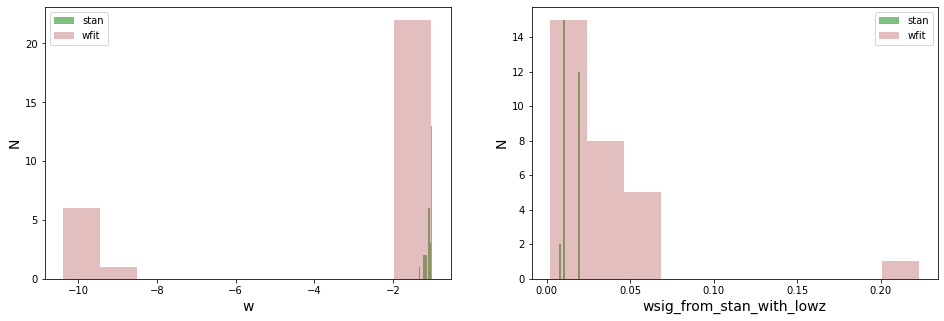

In [14]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.hist(data_all['stan_w_lowz'].values.astype(float), color='green', label='stan', alpha=0.5)
plt.hist(data_all['wfit_w_lowz'].values.astype(float), color='brown', label='wfit', alpha=0.3)
plt.xlabel('w', fontsize=14)
plt.ylabel('N', fontsize=14)
plt.legend()

plt.subplot(1,2,2)
plt.hist(data_all['stan_wsig_lowz'].values.astype(float), color='green', alpha=0.5, label='stan')
plt.hist(data_all['wfit_wsig_lowz'].values.astype(float), color='brown', label='wfit', alpha=0.3)
plt.xlabel('wsig_from_stan_with_lowz', fontsize=14)
plt.ylabel('N', fontsize=14)
plt.legend()

plt.show()

In [46]:
from astropy.cosmology import FlatLambdaCDM
    
cosmo = FlatLambdaCDM(H0=72, Om0=0.3)
theor_dist = [cosmo.distmod(z).value for z in np.arange(0.001,1.5,0.005)]

for name in cases:
    
    fname_cosmo_lowz = '/media/emille/git/COIN/RESSPECT_work/PLAsTiCC/metrics_paper/resspect_metric/' + \
                    'posteriors/DDF/' + name[:-4] + '/' + \
                    'Alex_samples/omprior_0.01_flat/results/test_salt2mu_lowz_withbias_' + name[:-4] + '.M0DIF.cospar'
    
    cosmofit = pd.read_csv(fname_cosmo_lowz, delim_whitespace=True,
                          comment='#', names=['w', 'wsig_marg',  'OM',  'OM_sig',  'chi2',  
                                              'Ndof',  'sigint', 'wran',  'OMran',  'label'])
    
    fname_fitres = name[:-4] + '/Alex_samples/omprior_0.01_flat/results/test_salt2mu_lowz_withbias_' + name[:-4] + '.fitres'
    fitres = pd.read_csv(fname_fitres, comment='#', delim_whitespace=True)
    
    flag = np.logical_or(fitres['SIM_TYPE_INDEX'].values == 11, fitres['SIM_TYPE_INDEX'].values == 1)
    z = fitres['SIM_ZCMB'].values
    mu = fitres['MU'].values
    muerr = fitres['MUERR'].values
    
    
    fig = plt.figure(figsize=(10,8))
        
    ax = fig.add_subplot(111)
    ax.set_title(name, fontsize=26)

    if sum(flag) > 0:
        plt.errorbar(z[flag], mu[flag], yerr=muerr[flag], fmt='o', alpha=0.1, label='spec-Ia', color='blue')
    
    if sum(~flag) > 0:
        plt.errorbar(z[~flag], mu[~flag], yerr=muerr[~flag], fmt='^', alpha=0.1, label='photo-Ia', color='green')
       
    plt.plot(np.arange(0.001, 1.5,0.005), theor_dist, label='w = -1', color='red')

    w = str(cosmofit['w'].values[0])
    if len(w) >= 6:
        w1 = w[:6]
    else:
        w1 = w.ljust(6, '0')
            
    werr = str(cosmofit['wsig_marg'].values[0])
    if len(werr) >= 6:
        werr1 = werr[:5]
    else:
        werr1 = werr.ljust(5, '0')
            
    flag_case = data_all['case'].values == name[:-4]
    ax.text(0.2, 32, 'stan = ' + str(data_all[flag_case]['stan_w_lowz'].values[0]) + r' $\pm$ ' + \
            str(data_all[flag_case]['stan_wsig_lowz'].values[0]), fontsize=20)
    ax.text(0.2, 30, r'wfit = ' + w1 + r' $\pm$ ' + werr1 , fontsize=20)
        
    ax.set_xlabel('redshift', fontsize=22)
    ax.set_ylabel('mu', fontsize=22)
    plt.legend(fontsize=22, loc='lower right')

    plt.savefig('plots/distances/omprior_0.01_flat/dist_' + name[:-4] + '.png')
    plt.close('all')

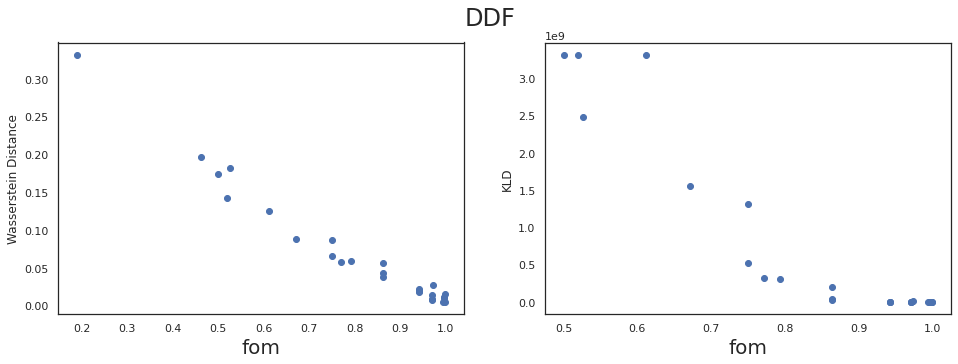

In [33]:
flag = np.array(['3000' in item for item in data_all['case'].values])

sns.set(style='white')

plt.figure(figsize=(16, 5))
plt.suptitle('DDF', fontsize=24)
plt.subplot(1,2,1)
plt.scatter(data_all[~flag]['fom3'], data_all[~flag]['WassersteinDistanceMedian'])
plt.xlabel('fom', fontsize=20)
plt.ylabel('Wasserstein Distance')

plt.subplot(1,2,2)
plt.scatter(data_all[~flag]['fom3'], data_all[~flag]['KLD'])
plt.xlabel('fom', fontsize=20)
plt.ylabel('KLD')

plt.savefig('plots/metrics_DDF.png')

In [27]:
data_all[['case','fom3','WassersteinDistanceMedian', 'KLD']]

,case,fom3,WassersteinDistanceMedian,KLD
0,86SNIa14SNIax,0.671875,0.087710,1.551851e+09
1,95SNIa5SNIbc,0.863636,0.056677,2.015456e+08
2,fiducial1500,0.526460,0.182618,2.487344e+09
3,99.1SNIa0.9CART,0.973477,0.026978,1.082688e+07
4,perfect1500,1.000000,0.004819,5.147909e+05
5,95SNIa5SNII,0.863636,0.042707,3.575439e+07
6,random6000,0.519946,0.141794,3.317096e+09
7,fiducial6000,0.611935,0.124922,3.311155e+09
8,perfect6000,1.000000,0.015844,5.399616e+06
9,99.9SNIa0.1AGN,0.997006,0.009687,1.176456e+06


# Save samples for Alberto

In [2]:
import pandas as pd
import os

flist = os.listdir('.')
flist.remove('summary_cases_omprior_0.01_flat_emille.csv')
flist.remove('summary.ipynb')
flist.remove('plots')
flist.remove('.ipynb_checkpoints')
flist.remove('summary_cases_omprior_0.01_flat.csv')

for case in flist:

    if os.path.isdir(case + '/test_mysamples/omprior_0.01_flat/'):
        name = '/media/emille/git/COIN/RESSPECT_work/PLAsTiCC/metrics_paper/resspect_metric/posteriors/DDF/' + case + '/' + \
               'test_mysamples/omprior_0.01_flat/chains/chains_' + case + '_lowz_withbias.pkl'
        data = pd.read_pickle(name)
        data2 = pd.DataFrame(data)

        data2.to_csv('/media/RESSPECT/data/PLAsTiCC/for_metrics/ddf/posteriors/samples_emille/' + \
                    'chains_'  + case + '_lowz_withbias.csv.gz', index=False)
        
    else:
        print(case)

90SNIa10SNIbc
perfect1000
83SNIa17SNIbc
94SNIa6SNIax
random1000
99SNIa1SNIa-91bg
98SNIa2AGN
50SNIa50SNII
68SNIa32SNII
98SNIa2SNIa-91bg
99SNIa1AGN
fiducial1000
